In [133]:
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy.special import legendre,eval_legendre
import scipy.interpolate as interpolate
import scipy.special

In [134]:

def lglnodes(N):

    N1 = N + 1
    x = np.cos(np.pi * np.arange(N1) / N)
    P = np.zeros((N1, N1))
    xold = 2 * np.ones_like(x)
    while np.max(np.abs(x - xold)) > np.finfo(float).eps:
        xold = x.copy()
        P[:, 0] = 1
        P[:, 1] = x
        for k in range(2, N1):
            P[:, k] = ((2 * k - 1) * x * P[:, k - 1] - (k - 1) * P[:, k - 2]) / k
        x = xold - (x * P[:, N] - P[:, N - 1]) / (N1 * P[:, N])
    w = 2 / (N * N1 * P[:, N]**2)
    return x, w


In [135]:
def D_matrix(nodes):
    n = len(nodes)
    wj = lambda j: 1/np.product(nodes[j]-np.delete(nodes,j,0))
    D = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            idxs = [m for m in range(len(nodes))]
            idxs.remove(j)
            D[i,j] = wj(j)* np.sum([np.product(nodes[i]-np.delete(nodes,[j,m])) for m in idxs])

    return D

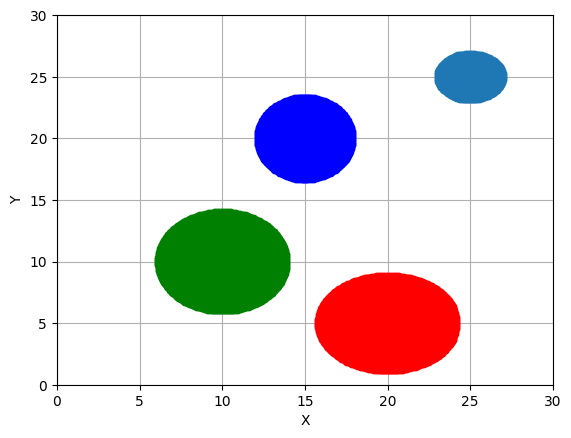

In [136]:
#Defining the obstacles
xc,yc = (10,10)
p = 2
a,b,c = np.random.randint(20,30,(3,))/10
def obstacle(x,y,xc,yc,a,b,c,p):
    return ((x-xc)/a)**p+((y-yc)/b)**p-c

obstacle1 = lambda x,y:obstacle(x,y,xc,yc,a,b,c,p)
xc2,yc2 = (15,20)
p2 = 2
a2,b2,c2 = np.random.randint(20,25,(3,))/10
obstacle2 = lambda x,y:obstacle(x,y,xc2,yc2,a2,b2,c2,p2)
xc3,yc3 = (20,5)
p3 = 2
a3,b3,c3 = np.random.randint(20,30,(3,))/10
obstacle3 = lambda x,y:obstacle(x,y,xc3,yc3,a3,b3,c3,p3)
xc4,yc4 = (25,25)
p4 = 2
a4,b4,c4 = np.random.randint(15,20,(3,))/10
obstacle4 = lambda x,y:obstacle(x,y,xc4,yc4,a4,b4,c4,p4)
#Visualizing the obstacles
domain_x = np.linspace(0,30,500)
domain_y = np.linspace(0,30,500)
obstacle_1x = []
obstacle_1y = []
obstacle_2x = []
obstacle_2y = []
obstacle_3x = []
obstacle_3y = []
obstacle_4x = []
obstacle_4y = []
for i in domain_x:
    for j in domain_y:
        if obstacle1(i,j)<=0:
            obstacle_1x.append(i)
            obstacle_1y.append(j)
        if obstacle2(i,j)<=0:
            obstacle_2x.append(i)
            obstacle_2y.append(j)
        if obstacle3(i,j)<=0:
            obstacle_3x.append(i)
            obstacle_3y.append(j)
        if obstacle4(i,j)<=0:
            obstacle_4x.append(i)
            obstacle_4y.append(j)
plt.figure()
plt.plot(obstacle_2x,obstacle_2y,".b")
plt.plot(obstacle_1x,obstacle_1y,".g")
plt.plot(obstacle_3x,obstacle_3y,'.r')
plt.plot(obstacle_4x,obstacle_4y,'.')
plt.xlim((0,30))
plt.ylim((0,30))
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.show()

In [137]:
import casadi as ca
import numpy as np

# Define obstacle soft constraint as a function of x, y positions
def obstacle_soft_cons(x, y):
    return ca.sumsqr(((ca.exp(ca.exp(-obstacle1(x, y) + 2)) - 1) ** 4 +
                      (ca.exp(ca.exp(-obstacle2(x, y) + 2)) - 1) ** 4 +
                      (ca.exp(ca.exp(-obstacle3(x, y) + 2)) - 1) ** 4) ** 0.125)

def obstacle_soft_constraints(x, y):
    return ca.sumsqr(
        ca.fmax(0, 2 - obstacle1(x, y)) +
        ca.fmax(0, 2 - obstacle2(x, y)) +
        ca.fmax(0, 2 - obstacle3(x, y))+
        ca.fmax(0, 2 - obstacle4(x, y))
    )

# Create optimization problem
opti = ca.Opti()

# Set number of nodes and LGL collocation properties
N = 30
nodes, weights = lglnodes(N)
D = D_matrix(nodes=nodes)

# Problem parameters
V, theta0, phi0, w0, X, Y, L = 0.5, np.pi, np.pi/2, 5, 30, 30, 3
mini, maxi = 0 * ca.DM.ones(N + 1, 1), ca.DM.ones(N + 1, 1)

# Define state and control variables
x = opti.variable(N + 1)      # X position
y = opti.variable(N + 1)      # Y position
theta = opti.variable(N + 1)  # Heading angle
v = opti.variable(N + 1)      # Velocity
phi = opti.variable(N + 1)    # Steering angle
w = opti.variable(N + 1)      # Angular rate
tf = opti.variable(1)         # Final time

# Set bounds on state variables
opti.subject_to(opti.bounded(mini, x, maxi))
opti.subject_to(opti.bounded(mini, y, maxi))
opti.subject_to(opti.bounded(mini, v, maxi))
opti.subject_to(opti.bounded(mini - 1, phi, maxi))
opti.subject_to(opti.bounded(mini - 1, w, maxi))

# Initial and final conditions
opti.subject_to(x[0] == 0)
opti.subject_to(y[0] == 0)
opti.subject_to(v[0] == 0)
opti.subject_to(x[-1] == 1)
opti.subject_to(y[-1] == 1)
opti.subject_to(theta[0] == 0)


# Dynamics constraints based on pseudospectral differentiation matrix
opti.subject_to(v * ca.cos(theta0 * theta) * (V * tf / (2 * X)) == ca.mtimes(D, x))
opti.subject_to(v * ca.sin(theta0 * theta) * (V * tf / (2 * Y)) == ca.mtimes(D, y))
opti.subject_to(v * ca.tan(phi0 * phi) * (V * tf / (2 * phi0 * L)) == ca.mtimes(D, theta))
opti.subject_to(w0 * tf / 2 * w == ca.mtimes(D, phi))


objective = tf**2+100*obstacle_soft_constraints(x*X,y*Y) 
opti.minimize(objective)

# Solver options
p_opts = {"expand": True}
s_opts = {
    "tol": 1e-6,
    "max_iter": 10000,
    "constr_viol_tol": 1e-3,
    "acceptable_constr_viol_tol": 1e-3,
}
opti.solver('ipopt', p_opts, s_opts)

# Solve the optimization problem

sol = opti.solve()
# Extract the solution
x_opt = sol.value(x)
y_opt = sol.value(y)
theta_opt = sol.value(theta)
v_opt = sol.value(v)
phi_opt = sol.value(phi)
w_opt = sol.value(w)
tf_opt = sol.value(tf)
print(f"Optimal final time: {tf_opt}")


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4191
Number of nonzeros in inequality constraint Jacobian.:      155
Number of nonzeros in Lagrangian Hessian.............:      342

Total number of variables............................:      187
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      130
Total number of inequality constraints...............:      155
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      155
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

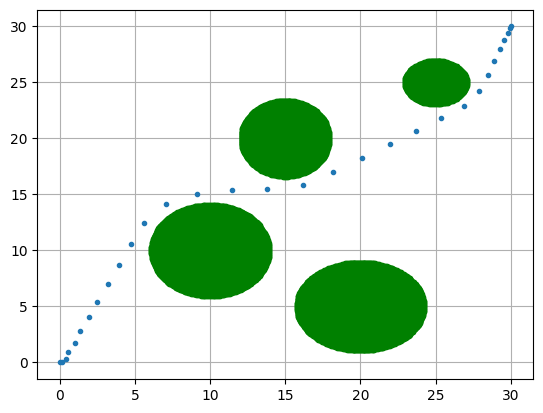

In [138]:

plt.plot(obstacle_1x,obstacle_1y,".g")
plt.plot(obstacle_2x,obstacle_2y,".g")
plt.plot(obstacle_3x,obstacle_3y,".g")
plt.plot(obstacle_4x,obstacle_4y,".g")
plt.plot(opti.debug.value(x)*X,opti.debug.value(y)*Y,'.')
plt.grid()
plt.show()